We process the Xenium5k spatial imaging data from a lung cancer patient in an x input vector

In [38]:
import scanpy as sc
import numpy as np
import pandas as pd
import scipy.sparse as sp
import matplotlib.pyplot as plt

#### Load in data and annotation file

In [15]:
adata = sc.read_h5ad("../data/xenium5k_luad_adata.h5ad")
sc.pp.filter_cells(adata, min_counts=1)
adata

filtered out 182 cells that have less than 1 counts


AnnData object with n_obs × n_vars = 278146 × 5001
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs'
    obsm: 'spatial'

In [16]:
annotation_file = "../data/cell_type_T3_refined.csv"
annotations = pd.read_csv(annotation_file)
annotations.head()

,cell_id,group
0,aaaaadnb-1,immune.T
1,aaaabalp-1,immune.T
2,aaaadfei-1,immune.T
3,aaaadjia-1,immune.T
4,aaaafglb-1,immune.T


In [17]:
adata.obs['cell_type'] = adata.obs['cell_id'].map(
    dict(zip(annotations['cell_id'], annotations['group']))
)

In [18]:
adata.obs['cell_type'].value_counts()

cell_type
stromal.fibroblast                   55364
immune.T                             50135
stromal.endothelial_blood            32970
epithelial.tumor_1                   31145
immune.myeloid                       27216
immune.B_2                            9706
stromal.SMC_1                         9455
epithelial.tumor_4                    9179
epithelial.normal_AT2                 8236
epithelial.normal_AT1                 7938
immune.B_1                            7332
epithelial.normal_ciliated_EPAS1+     6087
stromal.SMC_2                         5890
epithelial.normal_ciliated_FOXJ1+     4247
immune.mast                           3533
unassigned                            2867
stromal.pericyte                      1931
epithelial.tumor_2                    1537
epithelial.normal_neuroendocrine       981
stromal.endothelial_lymphatic          789
immune.B_3                             733
epithelial.tumor_3                     628
immune.neutrophils                     247
N

In [14]:
adata.obs['cell_type'].value_counts().sum()

np.int64(278146)

In [23]:
adata.obsm['spatial'].max(axis=0)

array([11467.05078125,  7913.09765625])

In [27]:
"PDCD1" in adata.var.index

True

In [28]:
"IFNG" in adata.var.index

True

#### Process adata into x

In [32]:
def grid_aggregate_5ch(
    adata,
    bin_size=50.0,                 # microns
    spatial_key="spatial",
    tumor_prefix="epithelial.tumor",
    tcell_prefix="immune.T",
    genes=("IFNG", "PDCD1"),
):
    # --- 0) coords & grid geometry ---
    coords = np.asarray(adata.obsm[spatial_key], dtype=float)  # (n_cells, 2) [x, y] in µm
    x, y = coords[:, 0], coords[:, 1]
    x_min, y_min = x.min(), y.min()
    x_max, y_max = x.max(), y.max()

    n_cols = int(np.floor((x_max - x_min) / bin_size)) + 1
    n_rows = int(np.floor((y_max - y_min) / bin_size)) + 1

    # tile index per cell
    ix = np.clip(((x - x_min) // bin_size).astype(int), 0, n_cols - 1)
    iy = np.clip(((y - y_min) // bin_size).astype(int), 0, n_rows - 1)
    gid = iy * n_cols + ix  # flattened grid id

    # --- 1) cell-type masks (prefix match, robust to NaN) ---
    ct = adata.obs.get("cell_type")
    if ct is None:
        raise ValueError("adata.obs['cell_type'] not found.")
    ct = ct.astype("string").fillna("")

    is_cancer = ct.str.startswith(tumor_prefix).to_numpy()
    is_tcell  = ct.str.startswith(tcell_prefix).to_numpy()

    # --- 2) gene indices & per-cell transcript counts ---
    varnames = pd.Index(adata.var_names)
    gene_idxs = []
    for g in genes:
        if g in varnames:
            gene_idxs.append(varnames.get_loc(g))
        else:
            gene_idxs.append(None)  # handle missing

    X = adata.X
    if sp.issparse(X):
        X = X.tocsr()

    # returns per-cell vector for a single gene (zeros if missing)
    def _gene_counts(gidx):
        if gidx is None:
            return np.zeros((adata.n_obs,), dtype=np.float32)
        # pull one gene (as column vector)
        if sp.issparse(X):
            # col is a sparse (n_cells x 1); densify safely
            col = X[:, gidx].toarray().ravel().astype(np.float32)
        else:
            col = np.asarray(X[:, gidx]).ravel().astype(np.float32)
        return col

    ifng_counts   = _gene_counts(gene_idxs[0])
    pdcd1_counts  = _gene_counts(gene_idxs[1])

    # --- 3) aggregate with np.add.at into flattened arrays ---
    n_tiles = n_rows * n_cols
    cancer_tile = np.zeros(n_tiles, dtype=np.float32)
    tcell_tile  = np.zeros(n_tiles, dtype=np.float32)
    ifng_tile   = np.zeros(n_tiles, dtype=np.float32)
    pdcd1_tile  = np.zeros(n_tiles, dtype=np.float32)

    np.add.at(cancer_tile, gid, is_cancer.astype(np.float32))
    np.add.at(tcell_tile,  gid, is_tcell.astype(np.float32))
    np.add.at(ifng_tile,   gid, ifng_counts)
    np.add.at(pdcd1_tile,  gid, pdcd1_counts)

    # --- 4) reshape to (rows, cols) and stack channels ---
    cancer_grid = cancer_tile.reshape(n_rows, n_cols)
    tcell_grid  = tcell_tile.reshape(n_rows, n_cols)
    ifng_grid   = ifng_tile.reshape(n_rows, n_cols)
    pdcd1_grid  = pdcd1_tile.reshape(n_rows, n_cols)
    placeholder = np.zeros_like(cancer_grid, dtype=np.float32)

    out = np.stack([cancer_grid, tcell_grid, ifng_grid, pdcd1_grid, placeholder], axis=-1)  # (rows, cols, 5)

    meta = {
        "bin_size_um": float(bin_size),
        "origin_xy_um": (float(x_min), float(y_min)),
        "n_rows": int(n_rows),
        "n_cols": int(n_cols),
        "channels": ["cancer_cell_count", "T_cell_count", "IFNG_transcript_count", "PDCD1_transcript_count", "placeholder"],
    }
    return out.astype(np.float32), meta


In [33]:
grid5, meta = grid_aggregate_5ch(adata, bin_size=50.0)
grid5.shape, meta

((156, 230, 5),
 {'bin_size_um': 50.0,
  'origin_xy_um': (9.33492660522461, 145.14759826660156),
  'n_rows': 156,
  'n_cols': 230,
  'channels': ['cancer_cell_count',
   'T_cell_count',
   'IFNG_transcript_count',
   'PDCD1_transcript_count',
   'placeholder']})

In [36]:
adata.obsm["spatial"].max(axis=0)/50

array([229.34101563, 158.26195312])

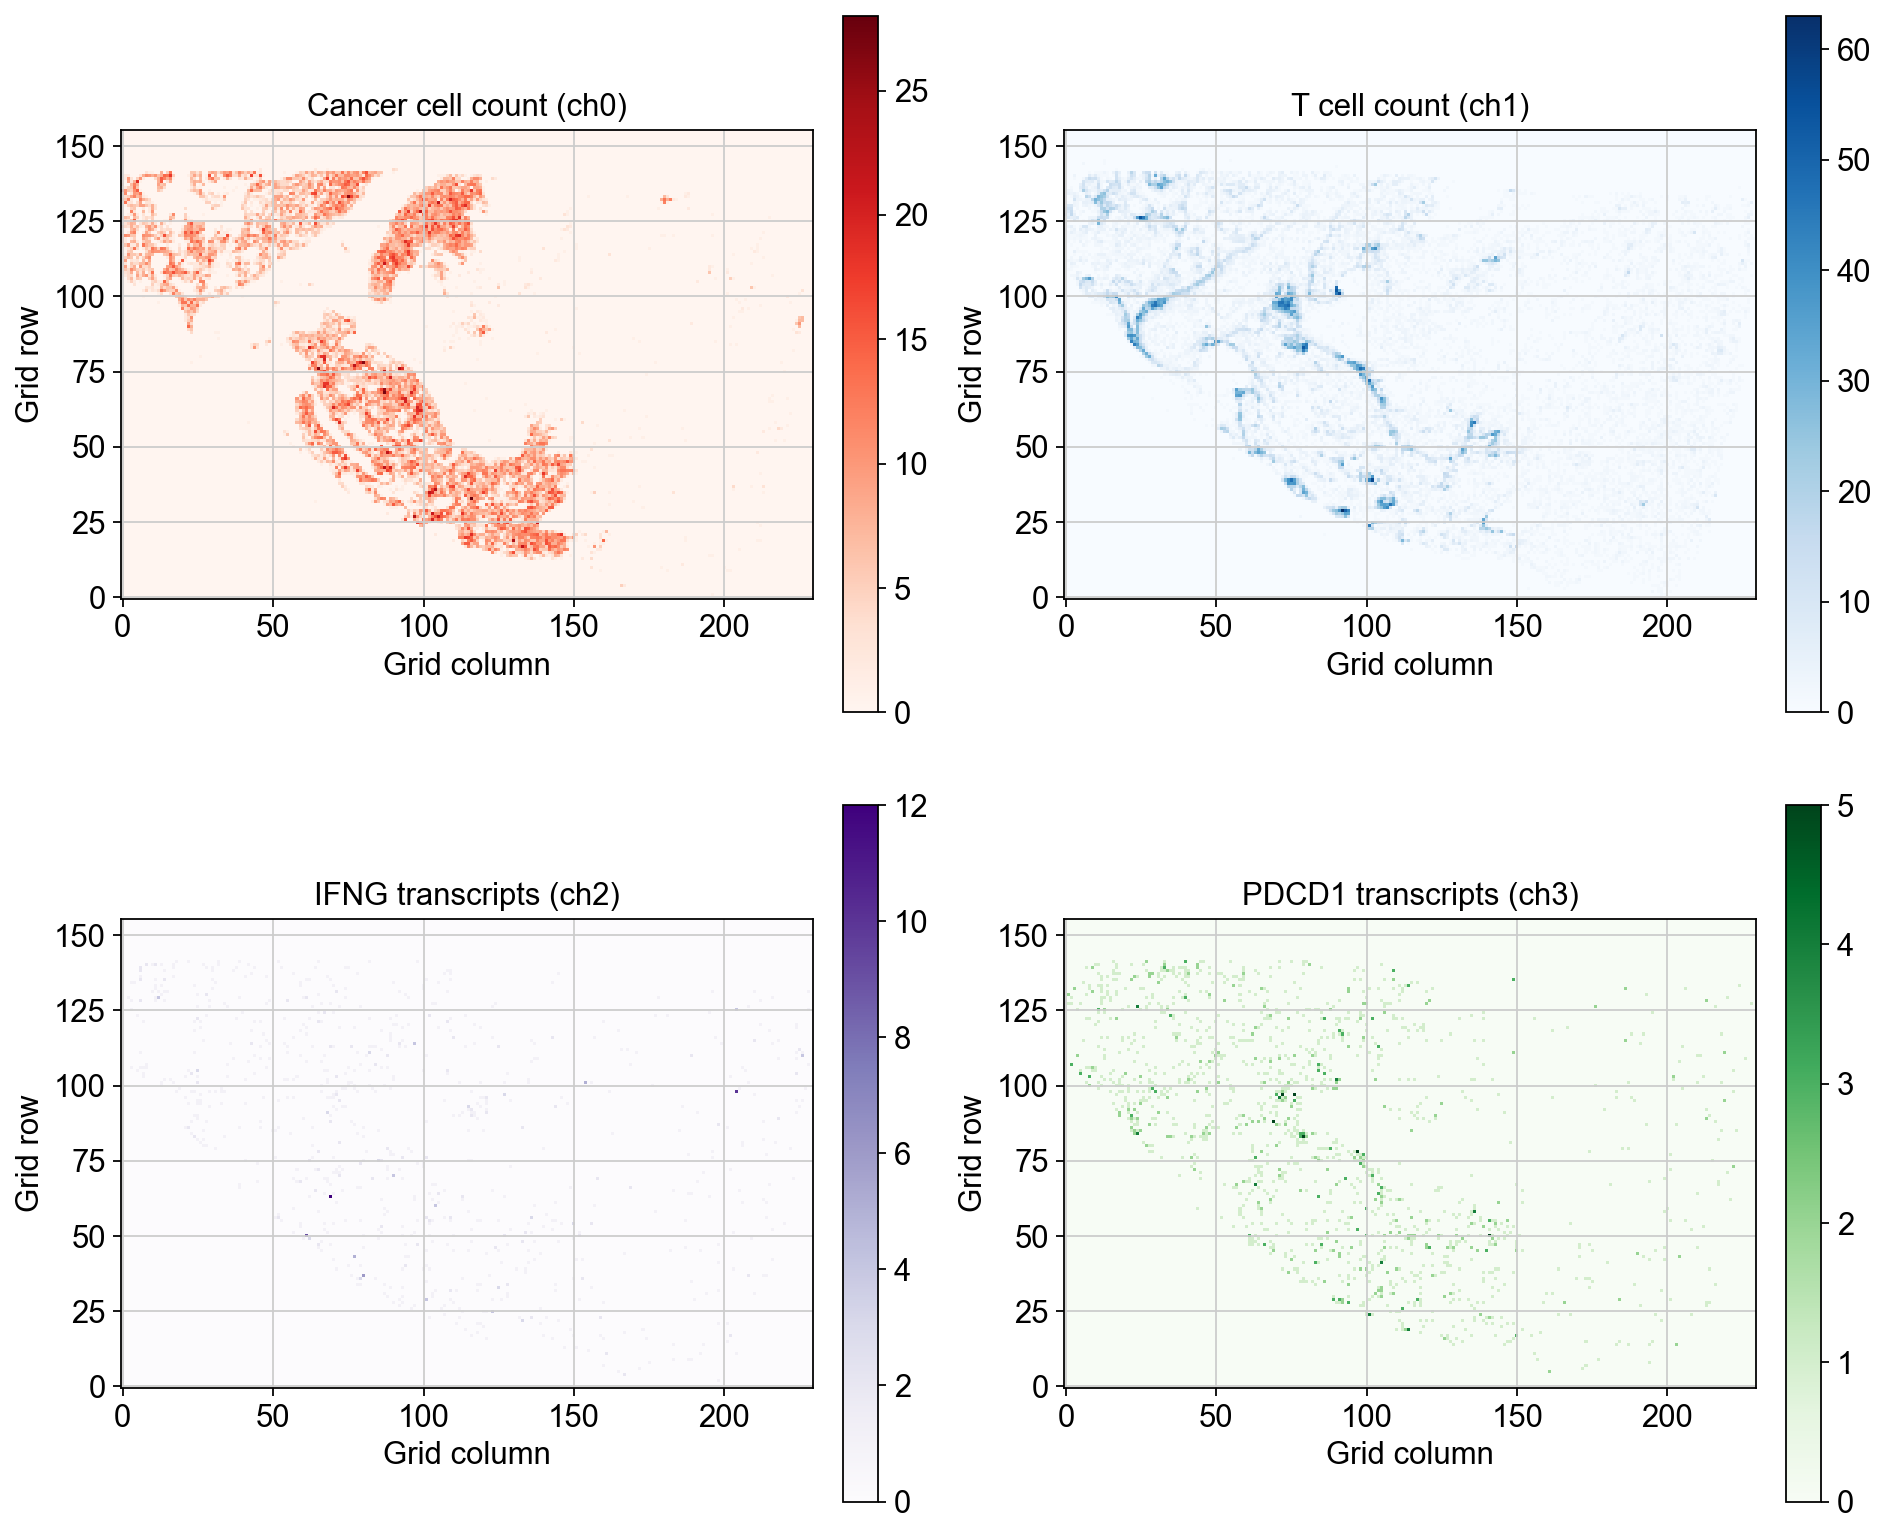

In [40]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

titles = [
    "Cancer cell count (ch0)",
    "T cell count (ch1)",
    "IFNG transcripts (ch2)",
    "PDCD1 transcripts (ch3)",
]

cmaps = ["Reds", "Blues", "Purples", "Greens"]

for i, ax in enumerate(axes.flat):
    data = grid5[:, :, i]
    im = ax.imshow(
        data,
        origin="lower",
        cmap=cmaps[i],
        interpolation="nearest"
    )
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(titles[i])
    ax.set_xlabel("Grid column")
    ax.set_ylabel("Grid row")

plt.tight_layout()
plt.show()

In [41]:
# save grid5 as npy
np.save("../data/xenium5k_luad_5ch_grid50um.npy", grid5)
# save meta as csv
pd.DataFrame([meta]).to_csv("../data/xenium5k_luad_5ch_grid50um_meta.csv", index=False)